# 2D trajectories of trees

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False

First, setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('../..'))
import analysis

FIG = os.path.join(os.path.abspath(os.path.curdir), '{}.png')
DB_NAME = 'spreadr_' + os.path.split(os.path.abspath(os.path.curdir))[1]
analysis.setup(DB_NAME)
print('Database:', DB_NAME)

Database: spreadr_exp_2


Then import all we need for the analysis

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Patch
import numpy as np
from pandas import DataFrame
import seaborn as sb
from sklearn.manifold import MDS

from gists.models import Sentence, Tree

from analysis.utils import grouper, memoized, mpl_palette

### 1.1 Trajectory plotting function

Define our trajectory plotting function

In [4]:
def plot_trajectories(x, y, **kwargs):
    data = kwargs.pop('data')
    x_name = y_name = ''
    if isinstance(x, str):
        x_name = x
        x = data[x_name].iloc
    if isinstance(y, str):
        y_name = y
        y = data[y_name].iloc
    ax = kwargs.get('ax', plt.gca())
    
    # Get indices
    indices = {}
    for i, sentence_id in enumerate(data['sentence id']):
        indices[sentence_id] = i
    # Check each sentence appears only once
    assert len(indices) == len(data['sentence id'])
    
    # Get sentences and leaves
    sentences = [Sentence.objects.get(id=id) for id in data['sentence id']]
    assert len(set(s.tree for s in sentences)) == 1
    tree = sentences[0].tree
    root = tree.root
    size = len(sentences)
    leaves = set([s for s in sentences if s.children.kept.count() == 0])
    
    # Define colors
    heads_indices = {}
    heads = root.children.kept.all()
    for i, head in enumerate(heads):
        heads_indices[head.id] = i
    cmap, palette = mpl_palette(len(heads_indices))
    
    # Plot sentences
    leaves_indices = [indices[leaf.id] for leaf in leaves]
    colors = np.array([(.5, .5, .5, 1)] * size)
    colors[indices[root.id]] = (1, 0, 0, 1)
    if len(leaves) > 0:
        colors[leaves_indices] = [palette[heads_indices[leaf.head.id]] for leaf in leaves]
    sizes = np.ones(size) * 50
    sizes[indices[root.id]] = 200
    if len(leaves) > 0:
        sizes[leaves_indices] = 200
    ax.scatter(x[:], y[:], c=colors, s=sizes, edgecolors=(0, 0, 0, 0))
    
    # Plot links
    links = [[s, child]
             for s in sentences
             for child in s.children.kept.all()
             if child in sentences]
    segments = [[[x[indices[s.id]], y[indices[s.id]]],
                 [x[indices[child.id]], y[indices[child.id]]]]
                for (s, child) in links]
    colors = np.array([heads_indices[child.head.id] for (_, child) in links])
    lc = LineCollection(segments,
                        zorder=1, cmap=cmap,
                        norm=plt.Normalize(0, colors.max()))
    lc.set_array(colors)
    lc.set_linewidths(1.5 * np.ones(len(segments)))
    ax.add_collection(lc)
    
    # Set legend data (seaborn catches legend stuff if we do it here,
    # so we return some data by this mechanism and use it in the
    # plotting code after FacetGrid.map_dataframe()).
    legends = kwargs.get('legends', None)
    if legends is not None:
        legend_handles = []
        for i, head in enumerate(heads):
            legend_handles.append(Patch(color=palette[heads_indices[head.id]],
                                        label='#{}'.format(head.id)))
        legends[tree.id] = legend_handles
    
    # Set chrome
    if kwargs.get('set_chrome', False):
        ax.set_title('tree id = {}'.format(tree.id))
        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)

## 2 Trajectories in length ~ difference from root

First generate our data (we'll use the same in all further plots)

In [5]:
trees = Tree.objects.experiment.all()
data = []
order = []
for tree in trees:
    root = tree.root
    root_length = len(root.content_words)
    order.append({'tree id': tree.id,
                  'root length': root_length})
    for sentence in tree.sentences.kept.all():
        if sentence.parent is None:
            rate = 0.0
            cumrate = 0.0
        else:
            rate = sentence.oc_distance(sentence.parent)
            cumrate = sentence.cum_root_distance('oc')
        length = len(sentence.content_words)
        data.append({'tree id': tree.id,
                     'sentence id': sentence.id,
                     'length': length,
                     'length / len(root)': length / root_length,
                     'diff from root': root.oc_distance(sentence, normalized=False) / root_length,
                     'depth': sentence.depth,
                     'rate': rate,
                     'cumrate': cumrate})
data = DataFrame(data)
root_order = DataFrame(order).sort_values(['root length', 'tree id'])

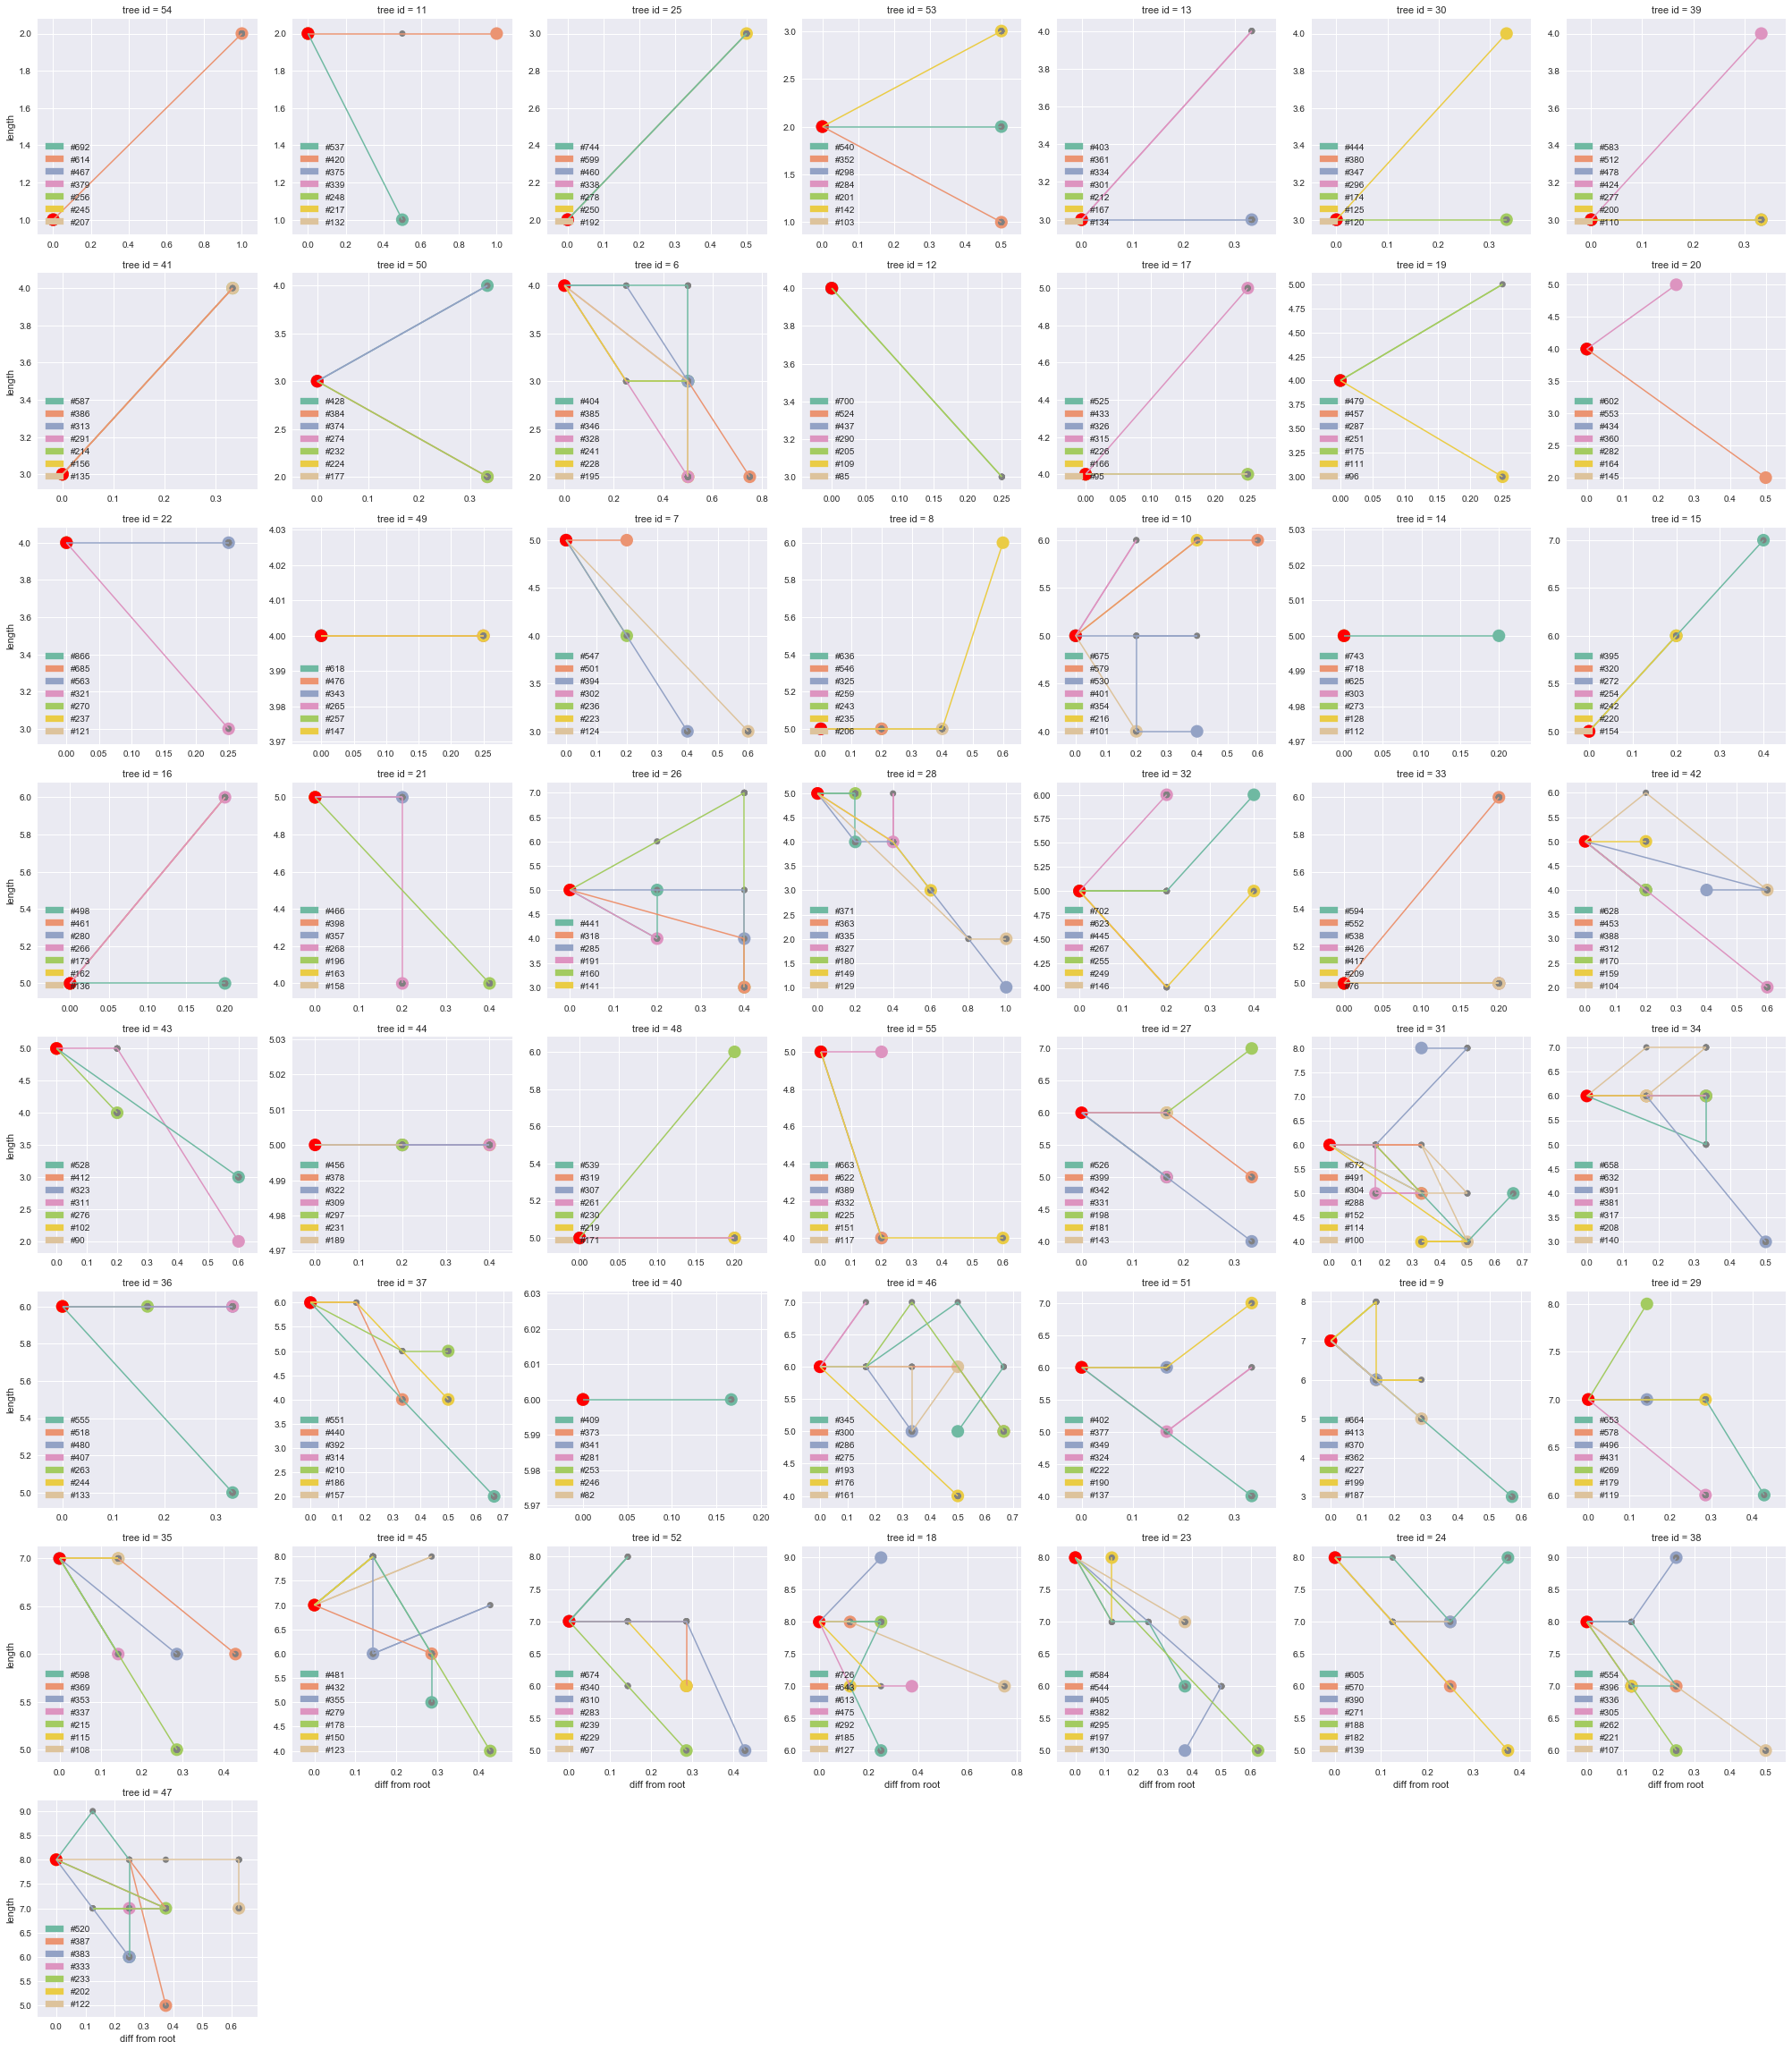

In [6]:
legends = {}
g = sb.FacetGrid(data, col='tree id', dropna=False,
                 sharex=False, sharey=False,
                 col_wrap=7, size=4, col_order=root_order['tree id'])
g.map_dataframe(plot_trajectories, 'diff from root', 'length',
                set_chrome=True, legends=legends);
for i, ax in enumerate(g.axes):
    ax.legend(handles=legends[root_order['tree id'].iloc[i]], loc='lower left')
if SAVE_FIGURES:
    g.savefig(FIG.format('trajectories_length-diffroot'), dpi=300)

## 3 Trajectories in difference from root ~ depth

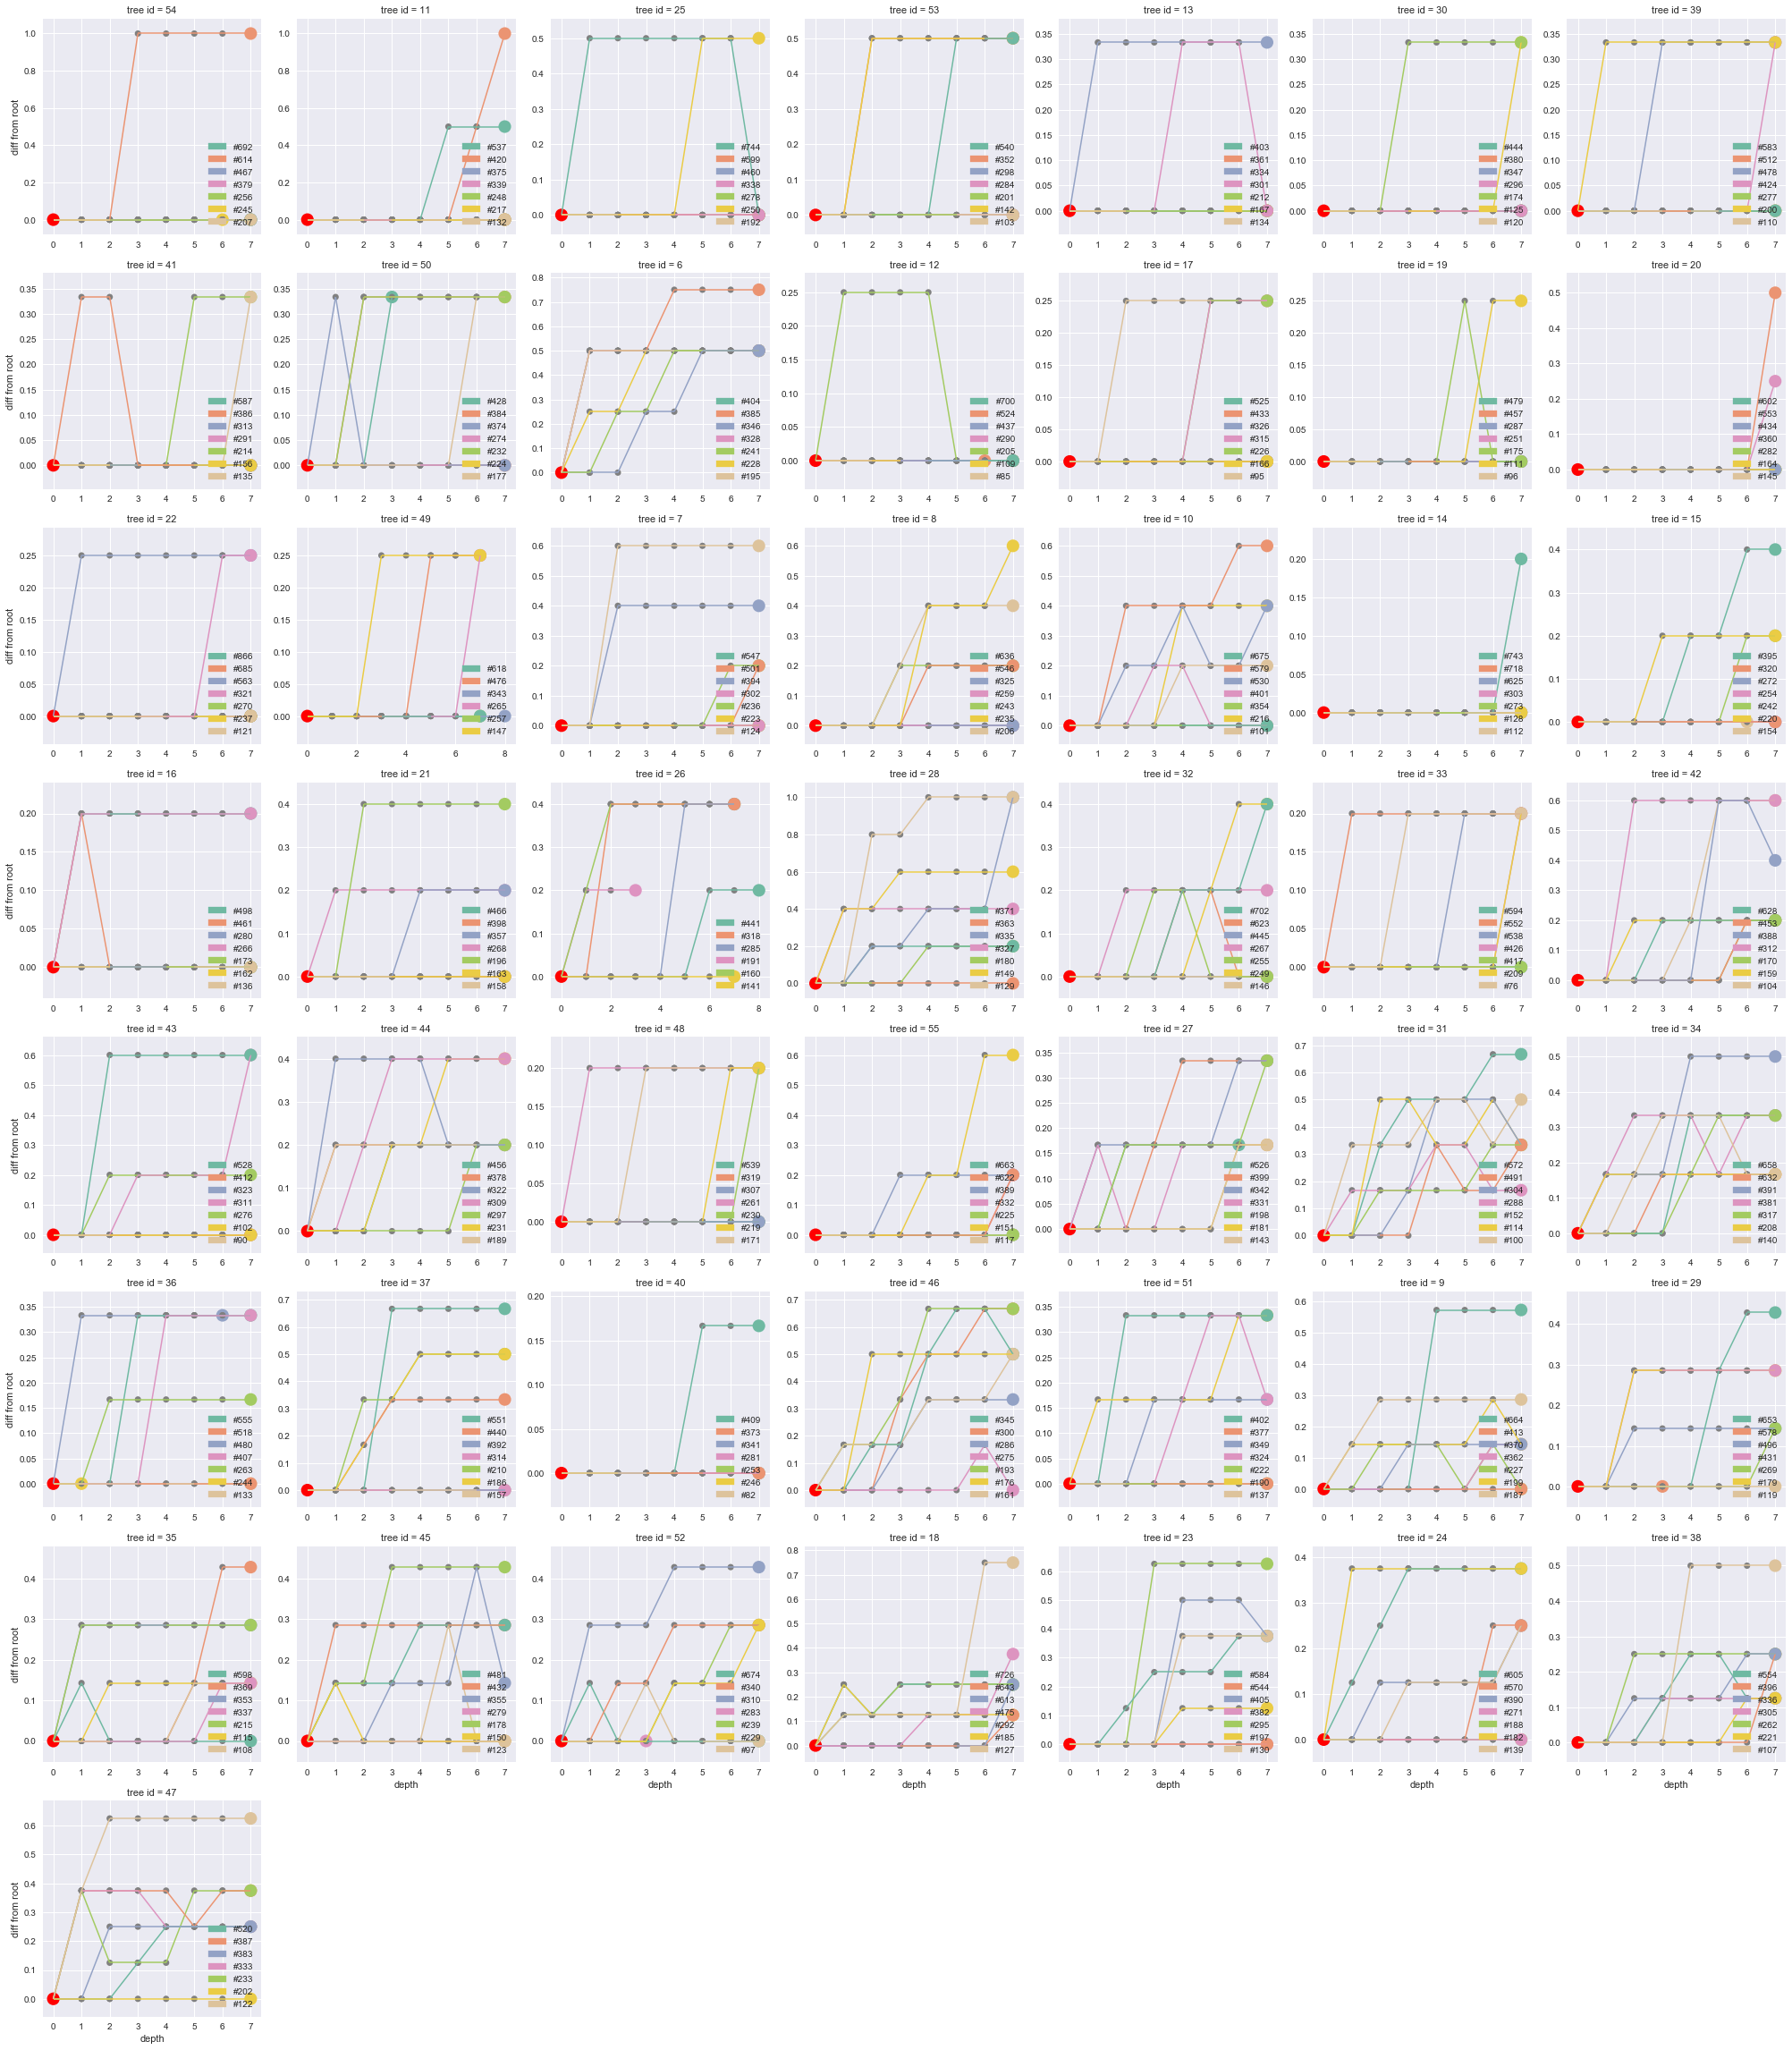

In [7]:
legends = {}
g = sb.FacetGrid(data, col='tree id', dropna=False,
                 sharex=False, sharey=False,
                 col_wrap=7, size=4, col_order=root_order['tree id'])
g.map_dataframe(plot_trajectories, 'depth', 'diff from root',
                set_chrome=True, legends=legends)
for i, ax in enumerate(g.axes):
    ax.legend(handles=legends[root_order['tree id'].iloc[i]], loc='lower right')
if SAVE_FIGURES:
    g.savefig(FIG.format('trajectories_diffroot_depth'), dpi=300)

## 4 Trajectories in cumulative transformation rate ~ depth

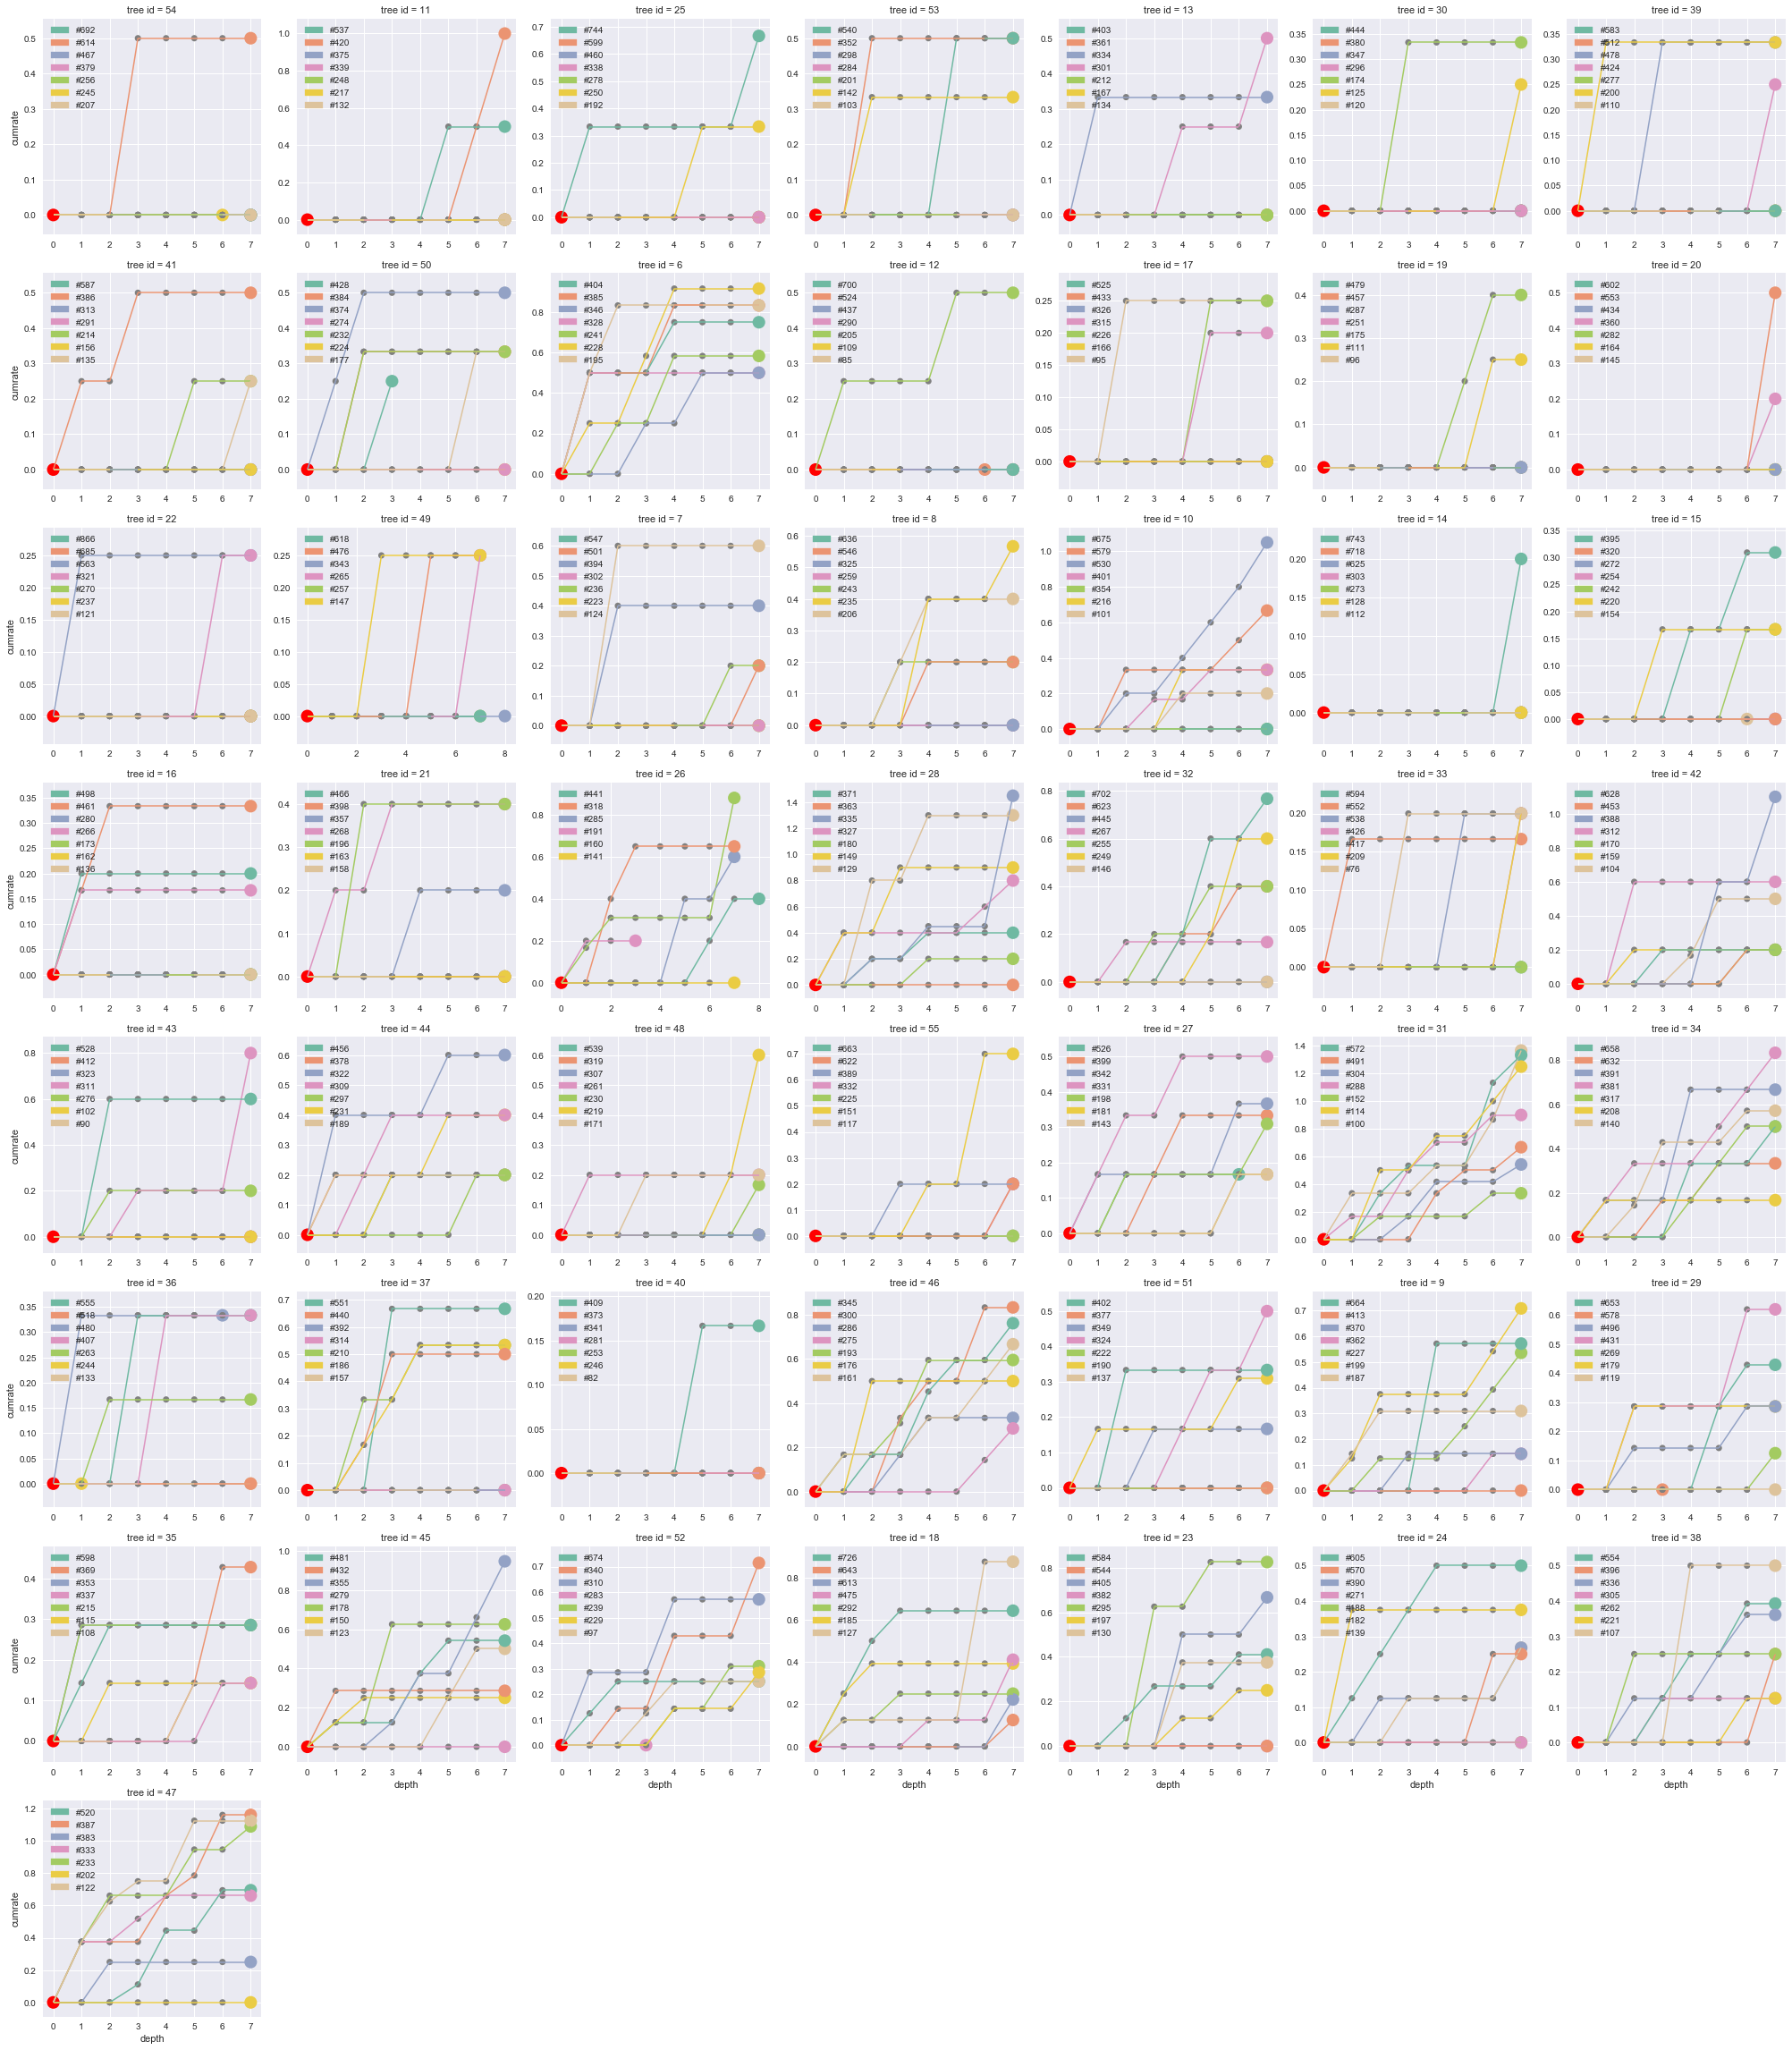

In [8]:
legends = {}
g = sb.FacetGrid(data, col='tree id',
                 sharex=False, sharey=False,
                 col_wrap=7, size=4, col_order=root_order['tree id'])
g.map_dataframe(plot_trajectories, 'depth', 'cumrate',
                set_chrome=True, legends=legends)
for i, ax in enumerate(g.axes):
    ax.legend(handles=legends[root_order['tree id'].iloc[i]], loc='upper left')
if SAVE_FIGURES:
    g.savefig(FIG.format('trajectories_cumtr-depth'), dpi=300)

## 5 Trajectories in length ~ depth

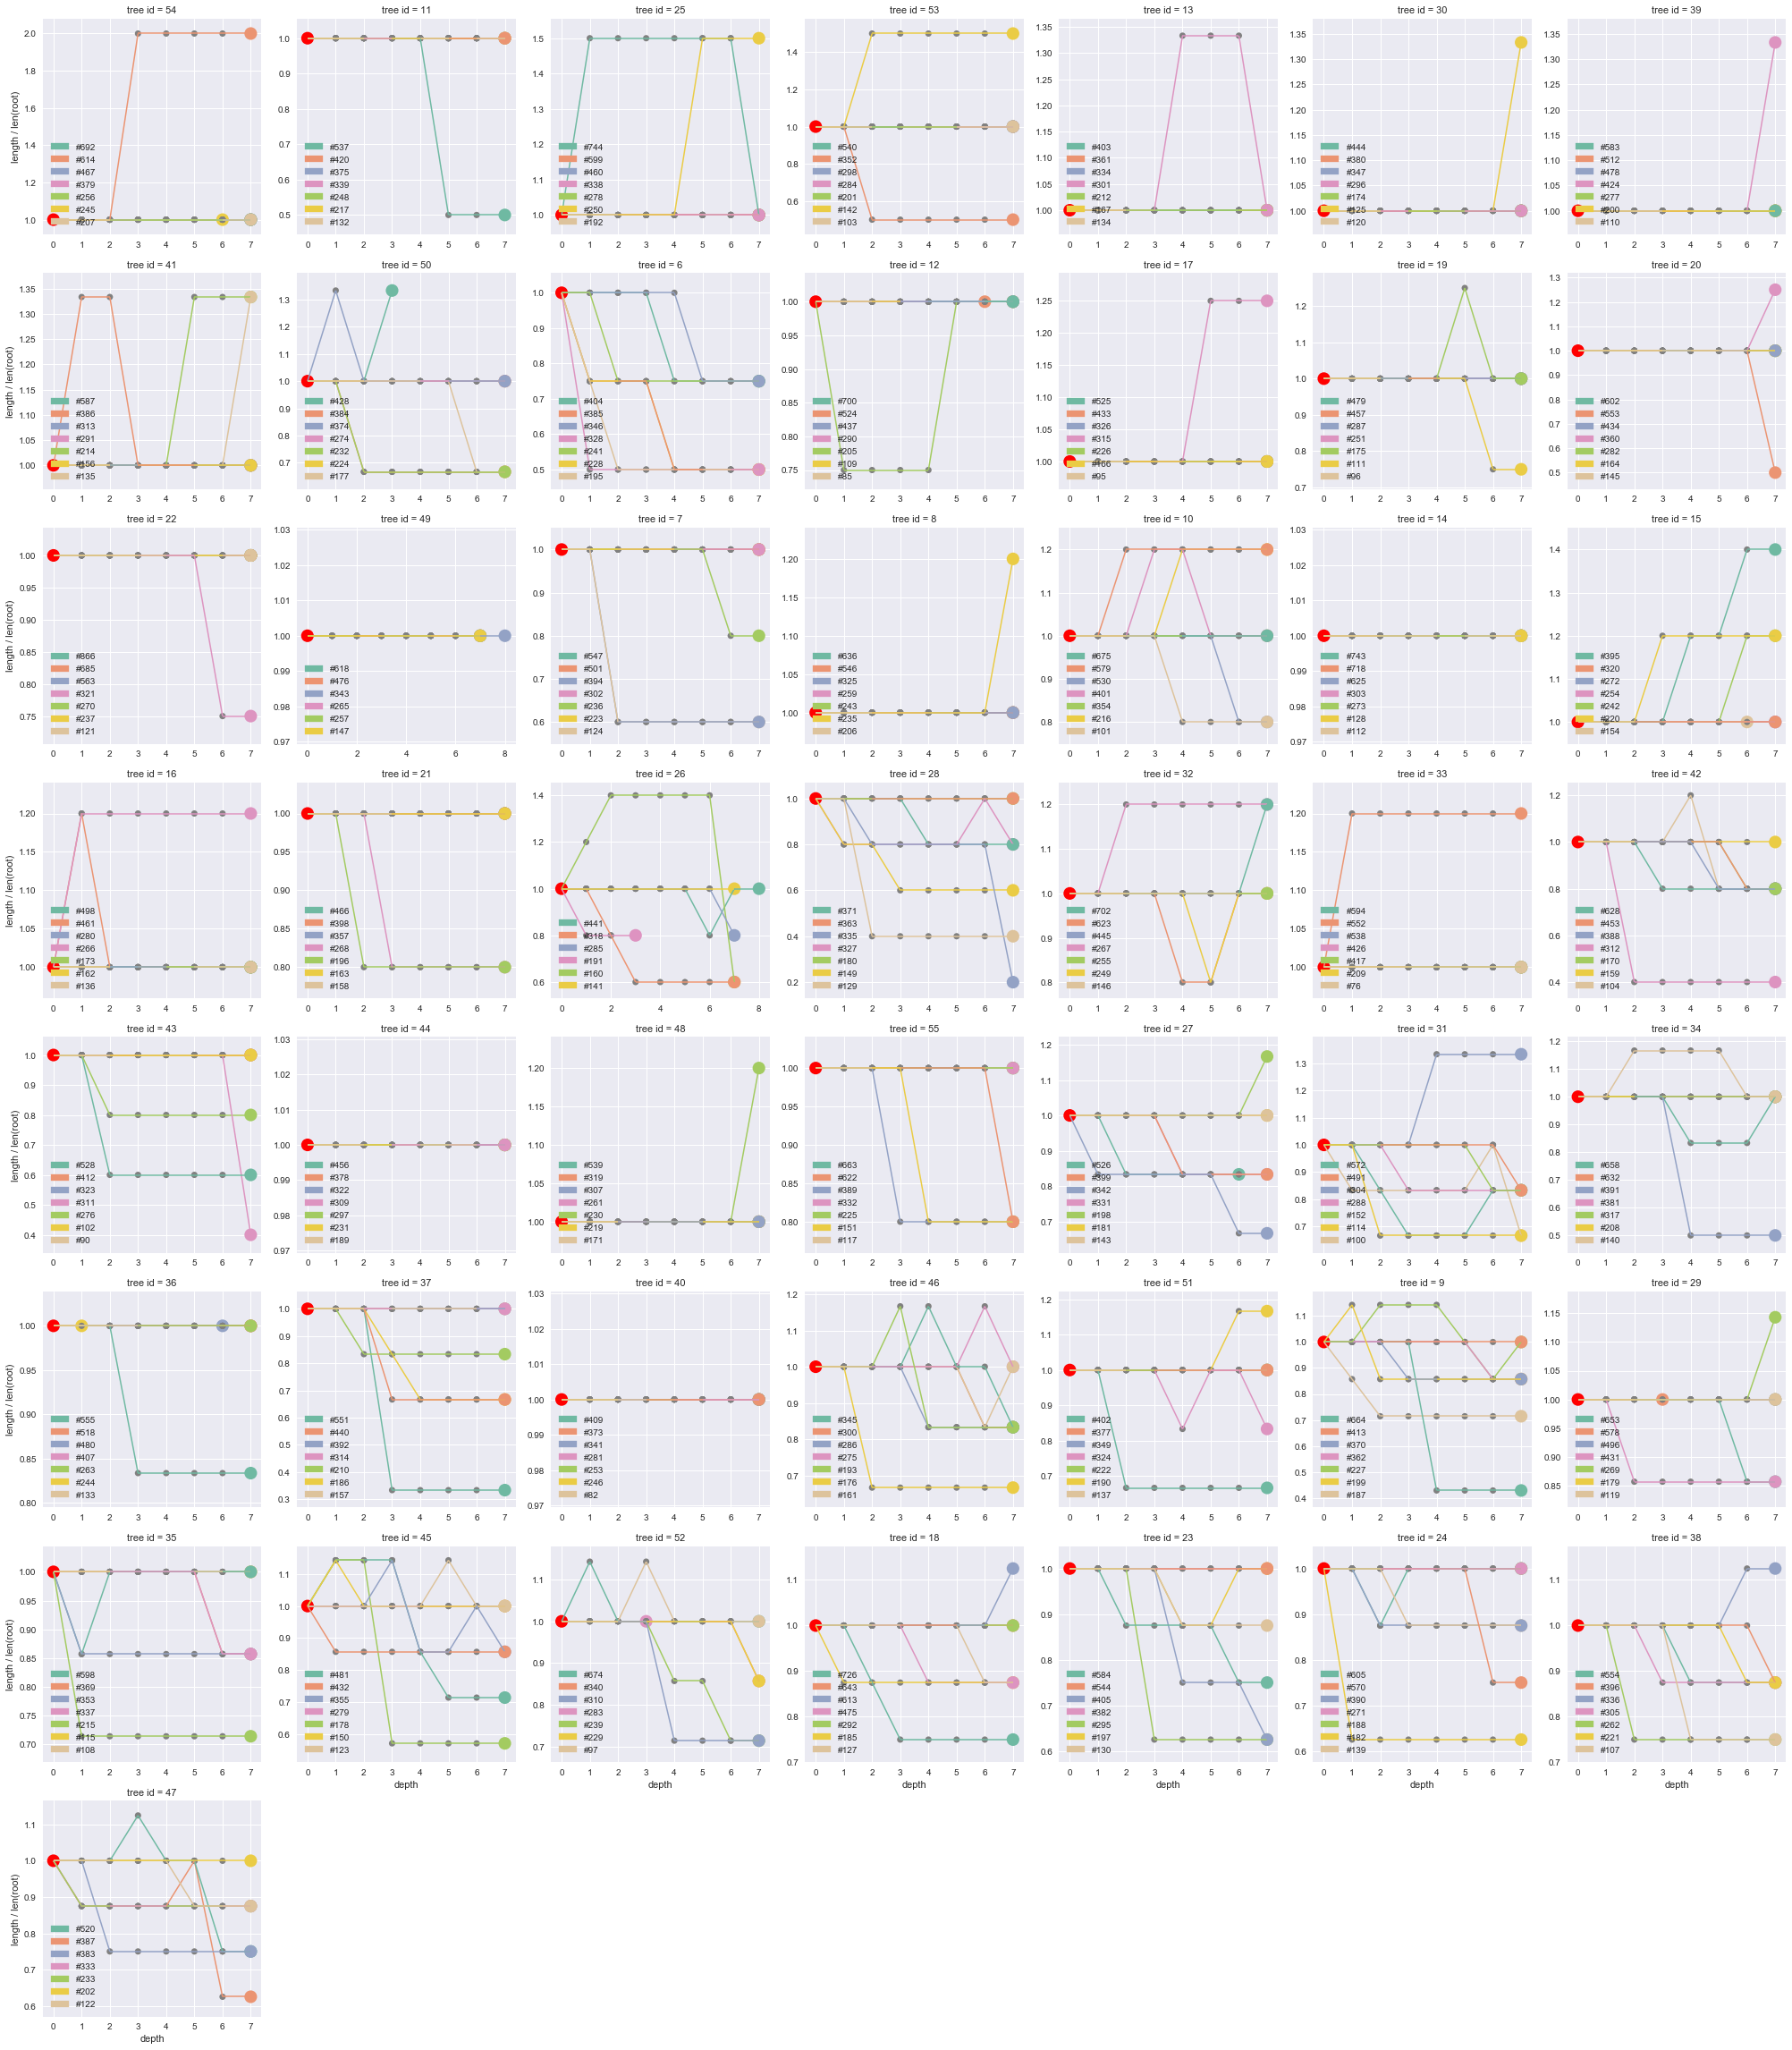

In [9]:
legends = {}
g = sb.FacetGrid(data, col='tree id', dropna=False,
                 sharex=False, sharey=False,
                 col_wrap=7, size=4, col_order=root_order['tree id'])
g.map_dataframe(plot_trajectories, 'depth', 'length / len(root)',
                set_chrome=True, legends=legends)
for i, ax in enumerate(g.axes):
    ax.legend(handles=legends[root_order['tree id'].iloc[i]], loc='lower left')
if SAVE_FIGURES:
    g.savefig(FIG.format('trajectories_length-depth'), dpi=300)